In [1]:
from collections import defaultdict
%load_ext autoreload
%autoreload 2
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

In [2]:
GLOVE_DIR = '/Users/ianmagnusson/IITUDND/data/extracted_features/combined_NLP/maria/'
TFIDF_DIR = '/Users/ianmagnusson/IITUDND/data/extracted_features/combined_NLP/maria/'

In [12]:
def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return



In [4]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    
    for i in range(2):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = 364, num_layers= 1, activation_function = torch.relu,
                                    learning_rate =  0.015103711963967328, momentum = 0.2094525986367598,
                                    decay_factor = 0.3093059390000923)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = 2)
        
        # evaluate
        running_acc += baseline.get_accuracy(torch.Tensor(X_test), torch.Tensor(y_test))
        running_auc += baseline.get_auc(torch.Tensor(X_test), torch.Tensor(y_test))
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test), X_hist_len_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)
    
    return running_acc/100, running_auc/100, bin_names, graph_results, priors_list




def get_auc(model, X_test,y_test):
    with torch.no_grad():
        y_score = model(torch.Tensor(X_test))
    
    y_score = torch.flatten(y_score).numpy()
    return roc_auc_score(y_test, y_score)


In [5]:
# retieve test data history sequence lengths from LSTM data
X_seq_tfidf_test = np.load(TFIDF_DIR + 'X_seq_tfidf_test.npz')
X_hist_len_test = [ torch.Tensor(X_seq_tfidf_test[file]).shape[0] for file in X_seq_tfidf_test.files]

In [6]:
# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train_glove = np.load(GLOVE_DIR + 'y_train.npy')
y_test_glove = np.load(GLOVE_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized, full data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)



In [8]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove


In [9]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

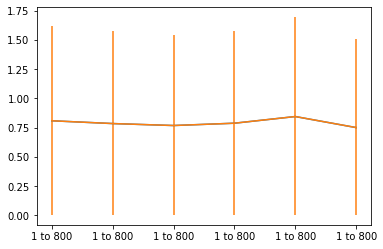

0.7904369538077403
0.8356871418144464


In [8]:
"""
import pickle

with open('bin_names.p', 'wb') as fout:
    pickle.dump(bin_names, fout)
    
with open('graph_results.p', 'wb') as fout:
    pickle.dump(graph_results, fout)
    

import pickle
with open('bin_names.p', 'rb') as fin:
    bin_names = pickle.load(fin)
with open('graph_results.p', 'rb') as fin:
    graph_results = pickle.load(fin)
"""

0.015942571785268412
0.016935418468858134


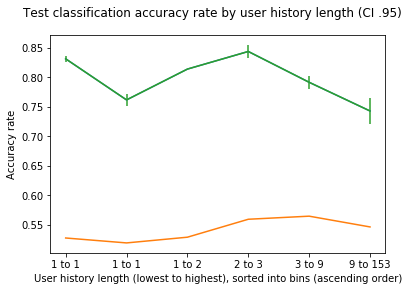

In [13]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# Normalized, without histories

In [9]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

y_train = y_train_glove
y_test = y_test_glove

In [10]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

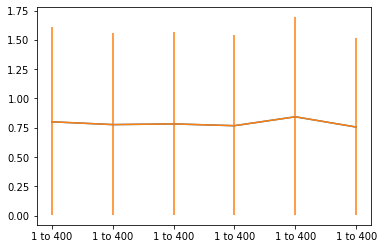

0.7874781523096128
0.8379736497080452


In [11]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

# MISC TESTS *************************************************************


# Unnormalized, full data NOTE THESE HAVE TO GO BEFORE NORMALIZATION
 

# Unnormalized, without user histories

# Now with just user histories


# Now with just tfidf

# Now with just glove

# Now glove without histories

# Try normalized (MINMAX)